# HW5

### Импортируем библеотеки

In [152]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso,  ElasticNet
from sklearn.ensemble import RandomForestRegressor
from scipy import cluster
from scipy.cluster.vq import kmeans
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import os, graphviz,pydotplus

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")


pd.set_option('max_rows', 15, 'max_columns', 500, 'max_colwidth', 1, 'precision', 2)
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
sns.set()
plt.rcParams['figure.figsize'] = [16, 6]

### Загружаем data frame

In [153]:
data = pd.read_csv("AB_NYC_2019.csv")

In [154]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


### Убираем ненужное 

In [155]:
data = data.drop(["id", "name", "host_id", "host_name", "last_review", "neighbourhood"], axis = 1)

In [156]:
data.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.65,-73.97,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75,-73.98,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.81,-73.94,Private room,150,3,0,NaN,1,365
3,Brooklyn,40.69,-73.96,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.80,-73.94,Entire home/apt,80,10,9,0.10,1,0


### Проверяем пропущенные значения

In [157]:
np.round(data.isna().sum()[data.isna().sum()>0] / data.shape[0], 2)

reviews_per_month    0.21
dtype: float64

## Варианты заполнения пропущенных значений

### Убираем строки

In [158]:
print(f'Данных останется {100*data.dropna().shape[0] / data.shape[0]} %')

Данных останется 79.44166070150322 %


#### Возможно пустые значения можно заполнить?

### Смотрим корреляцию reviews_per_month c price

In [159]:
print(f'Общее влияние data.reviews_per_month на целевую переменную: {data.reviews_per_month.corr(data.price)}')

Общее влияние data.reviews_per_month на целевую переменную: -0.030608348567533118


### Влияние на целевую переменную при различных способах заполнения

In [160]:
list_to_check = [0, data.reviews_per_month.min(), data.reviews_per_month.max(), data.reviews_per_month.mean(), data.reviews_per_month.median(),\
                    data.reviews_per_month.quantile(0.3), data.reviews_per_month.quantile(0.4), data.reviews_per_month.quantile(0.6),\
                   data.reviews_per_month.quantile(0.7)]

list_of_names = ['0', 'min', 'max', 'mean', 'median', 'quantile 0.3', 'quantile 0.4', 'quantile 0.6', 'quantile 0.7']
list_of_methods = ['bfill', 'ffill']

In [161]:
for el in list_to_check:
    print('Метод: {}, влияние на целевую переменную: {:.4f}'.format(list_of_names[list_to_check.index(el)], \
                                                     data.reviews_per_month.fillna(el).corr(data.price)))
for el in list_of_methods:
    print('Метод: {}, влияние на целевую переменную: {:.4f}'.format(el, \
                                                     data.reviews_per_month.fillna(method=el).corr(data.price)))

Метод: 0, влияние на целевую переменную: -0.0506
Метод: min, влияние на целевую переменную: -0.0504
Метод: max, влияние на целевую переменную: 0.0835
Метод: mean, влияние на целевую переменную: -0.0224
Метод: median, влияние на целевую переменную: -0.0368
Метод: quantile 0.3, влияние на целевую переменную: -0.0459
Метод: quantile 0.4, влияние на целевую переменную: -0.0427
Метод: quantile 0.6, влияние на целевую переменную: -0.0295
Метод: quantile 0.7, влияние на целевую переменную: -0.0150
Метод: bfill, влияние на целевую переменную: -0.0163
Метод: ffill, влияние на целевую переменную: -0.0168


### Заменим нулями

In [162]:
data = data.fillna(0)

In [163]:
data.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.65,-73.97,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75,-73.98,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.81,-73.94,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.69,-73.96,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.80,-73.94,Entire home/apt,80,10,9,0.10,1,0


### Работа с аномалиями


In [164]:
price_raw = data['price'].values
 
price_raw = price_raw.reshape(-1, 1)
price_raw = price_raw.astype('float64')


centroids, avg_distance = kmeans(price_raw, 4)

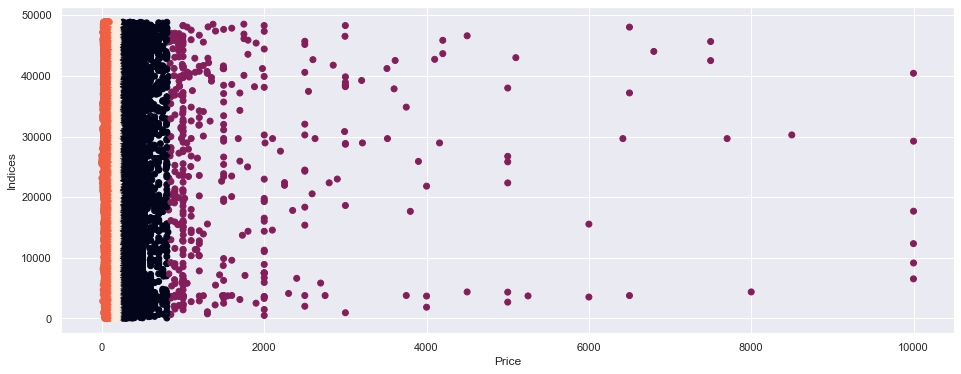

In [165]:
groups, cdist = cluster.vq.vq(price_raw, centroids)


plt.scatter(price_raw, np.arange(0,price_raw.shape[0]), c=groups)
plt.xlabel('Price')
plt.ylabel('Indices')
plt.show()



In [166]:
count1 = data['price'][data['price'] == 0].count()
print(f"Количество цен равных 0: {count1}")
count2 = data['price'][data['price'] > 800].count()
print(f"Количество цен больше 800: {count2}")

print(f'Указанные данные составляют всего {((count1+count2)/len(data))*100} % от всех данных')

Количество цен равных 0: 11
Количество цен больше 800: 420
Указанные данные составляют всего 0.881480724000409 % от всех данных


### Уберем аномалии

In [167]:
data = data[(data['price'] != 0) & (data['price'] < 800)]

In [168]:
data.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.65,-73.97,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75,-73.98,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.81,-73.94,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.69,-73.96,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.80,-73.94,Entire home/apt,80,10,9,0.10,1,0


In [169]:
price_raw = data['price'].values
 
price_raw = price_raw.reshape(-1, 1)
price_raw = price_raw.astype('float64')


centroids, avg_distance = kmeans(price_raw, 4)

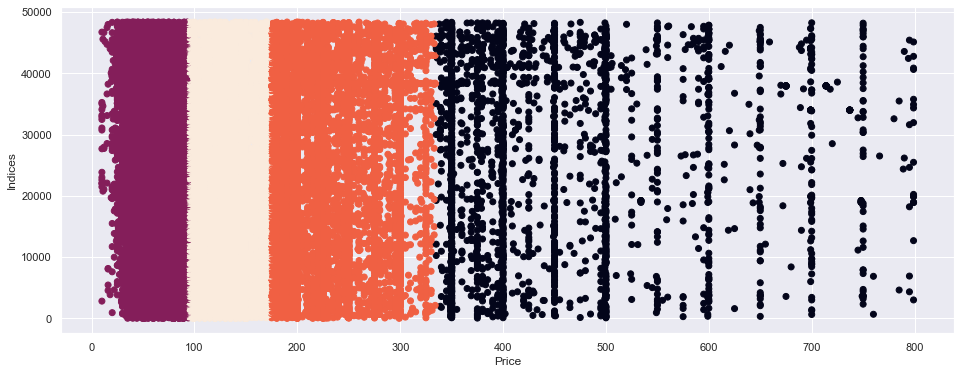

In [170]:
groups, cdist = cluster.vq.vq(price_raw, centroids)


plt.scatter(price_raw, np.arange(0,price_raw.shape[0]), c=groups)
plt.xlabel('Price')
plt.ylabel('Indices')
plt.show()


### Смотрим дорогие районы

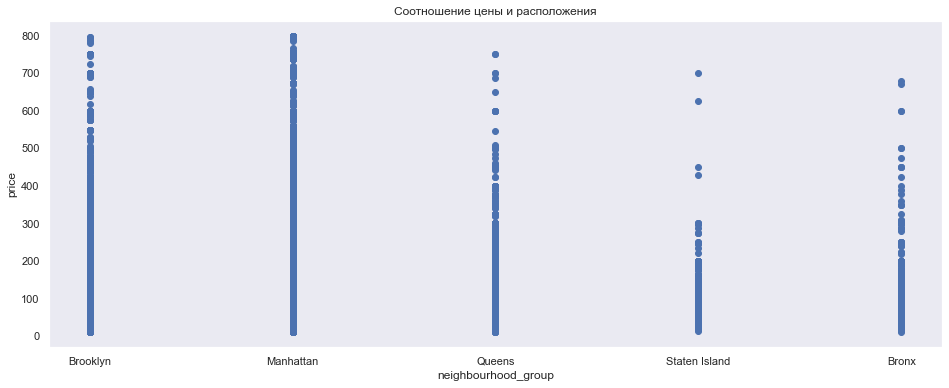

In [171]:
plt.scatter(data.neighbourhood_group, data.price)
plt.xlabel('neighbourhood_group')
plt.ylabel('price')
plt.grid()
plt.title('Соотношение цены и расположения') 
plt.show()

In [172]:
data.groupby("neighbourhood_group")["price"].mean()

neighbourhood_group
Bronx            83.86 
Brooklyn         115.92
Manhattan        172.90
Queens           94.10 
Staten Island    94.24 
Name: price, dtype: float64

### Объеденяем переменные и создаем новую, показывающую расстоение до самого дорогого района

In [173]:
def distance_calc(row):  
    result = math.sqrt((row['latitude']-40.77)**2 + (row['longitude']+73.99)**2)
    return result

In [174]:
data['distance'] = data.apply(lambda row: distance_calc(row), axis=1)
data = data.drop(["latitude", "longitude"], axis = 1)

In [175]:
data.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance
0,Brooklyn,Private room,149,1,9,0.21,6,365,0.12
1,Manhattan,Entire home/apt,225,1,45,0.38,2,355,0.02
2,Manhattan,Private room,150,3,0,0.00,1,365,0.06
3,Brooklyn,Entire home/apt,89,1,270,4.64,1,194,0.09
4,Manhattan,Entire home/apt,80,10,9,0.10,1,0,0.05


### Работа с категориальными переменными

In [176]:
data = pd.get_dummies(data, columns=["neighbourhood_group", "room_type"], prefix=["neighbourhood", "rooms"])

### DataFrame готов 

In [177]:
data.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance,neighbourhood_Bronx,neighbourhood_Brooklyn,neighbourhood_Manhattan,neighbourhood_Queens,neighbourhood_Staten Island,rooms_Entire home/apt,rooms_Private room,rooms_Shared room
0,149,1,9,0.21,6,365,0.12,0,1,0,0,0,0,1,0
1,225,1,45,0.38,2,355,0.02,0,0,1,0,0,1,0,0
2,150,3,0,0.00,1,365,0.06,0,0,1,0,0,0,1,0
3,89,1,270,4.64,1,194,0.09,0,1,0,0,0,1,0,0
4,80,10,9,0.10,1,0,0.05,0,0,1,0,0,1,0,0


## Разделяем на обучение и тест

In [178]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('price', axis=1), data.price, \
                                                    test_size=0.33, random_state=42)

## Нормируем данные

In [203]:
scalers =  StandardScaler(), RobustScaler(), MinMaxScaler(),  
models = LinearRegression(), Ridge(alpha = 100), Lasso(alpha = 100), ElasticNet(alpha = 0.5,  l1_ratio= 0.5),
all_res = []


for e in scalers:
    print(f'\033[1m{str(e)}\033[0m')
    scaler = e
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    for j in models:
        print(f' \033[1m{str(j)}\033[0m')
        model = j
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        y_column = "price"
        X_columns = data.columns[data.columns != y_column]
        clf = DecisionTreeClassifier(max_depth=4, criterion='gini')
        clf.fit(X_train, y_train)
        clf.feature_importances_
        print(pd.DataFrame(clf.feature_importances_, index = list(X_columns), columns = ['feature importance']).sort_values('feature importance', ascending = False))
        df = pd.DataFrame({"Scaler":[str(e)], "Model":[str(j)], "Test RMSE":[mean_squared_error(y_test, y_pred, squared = False)], "Train RMSE":[mean_squared_error(y_train, y_train_pred, squared = False)], "Test MAE":[mean_absolute_error(y_test, y_pred)], "Train MAE":[mean_absolute_error(y_train, y_train_pred)], "Test R2":[r2_score(y_test, y_pred)], "Train R2":[r2_score(y_train, y_train_pred)]})
        all_res.append(df)

data_metrics = pd.concat(all_res)    
    

StandardScaler()
 LinearRegression()
                                feature importance
rooms_Entire home/apt           0.54              
distance                        0.26              
calculated_host_listings_count  0.10              
rooms_Private room              0.03              
neighbourhood_Manhattan         0.03              
availability_365                0.03              
neighbourhood_Brooklyn          0.01              
minimum_nights                  0.00              
number_of_reviews               0.00              
reviews_per_month               0.00              
neighbourhood_Bronx             0.00              
neighbourhood_Queens            0.00              
neighbourhood_Staten Island     0.00              
rooms_Shared room               0.00              
 Ridge(alpha=100)
                                feature importance
rooms_Entire home/apt           0.54              
distance                        0.26              
calculated_host_listings_co

                                feature importance
rooms_Entire home/apt           0.54              
distance                        0.26              
calculated_host_listings_count  0.10              
rooms_Shared room               0.03              
neighbourhood_Manhattan         0.03              
availability_365                0.03              
neighbourhood_Brooklyn          0.01              
minimum_nights                  0.00              
number_of_reviews               0.00              
reviews_per_month               0.00              
neighbourhood_Bronx             0.00              
neighbourhood_Queens            0.00              
neighbourhood_Staten Island     0.00              
rooms_Private room              0.00              


In [205]:
data_metrics.reset_index(drop=True)

,Scaler,Model,Test RMSE,Train RMSE,Test MAE,Train MAE,Test R2,Train R2
0,StandardScaler(),LinearRegression(),81.80,83.93,52.05,52.63,3.64e-01,0.35
1,StandardScaler(),Ridge(alpha=100),81.80,83.93,52.04,52.61,3.64e-01,0.35
2,StandardScaler(),Lasso(alpha=100),102.61,104.35,73.21,73.55,-2.60e-05,0.00
3,StandardScaler(),ElasticNet(alpha=0.5),82.10,84.36,51.93,52.46,3.60e-01,0.35
4,RobustScaler(),LinearRegression(),81.80,83.93,52.05,52.63,3.64e-01,0.35
5,RobustScaler(),Ridge(alpha=100),81.80,83.93,52.03,52.60,3.64e-01,0.35
6,RobustScaler(),Lasso(alpha=100),101.53,103.15,71.91,72.24,2.09e-02,0.02
7,RobustScaler(),ElasticNet(alpha=0.5),83.94,86.03,53.79,54.24,3.31e-01,0.32
8,MinMaxScaler(),LinearRegression(),81.80,83.93,52.05,52.63,3.64e-01,0.35
9,MinMaxScaler(),Ridge(alpha=100),81.85,84.35,51.90,52.56,3.64e-01,0.35


# Выводы

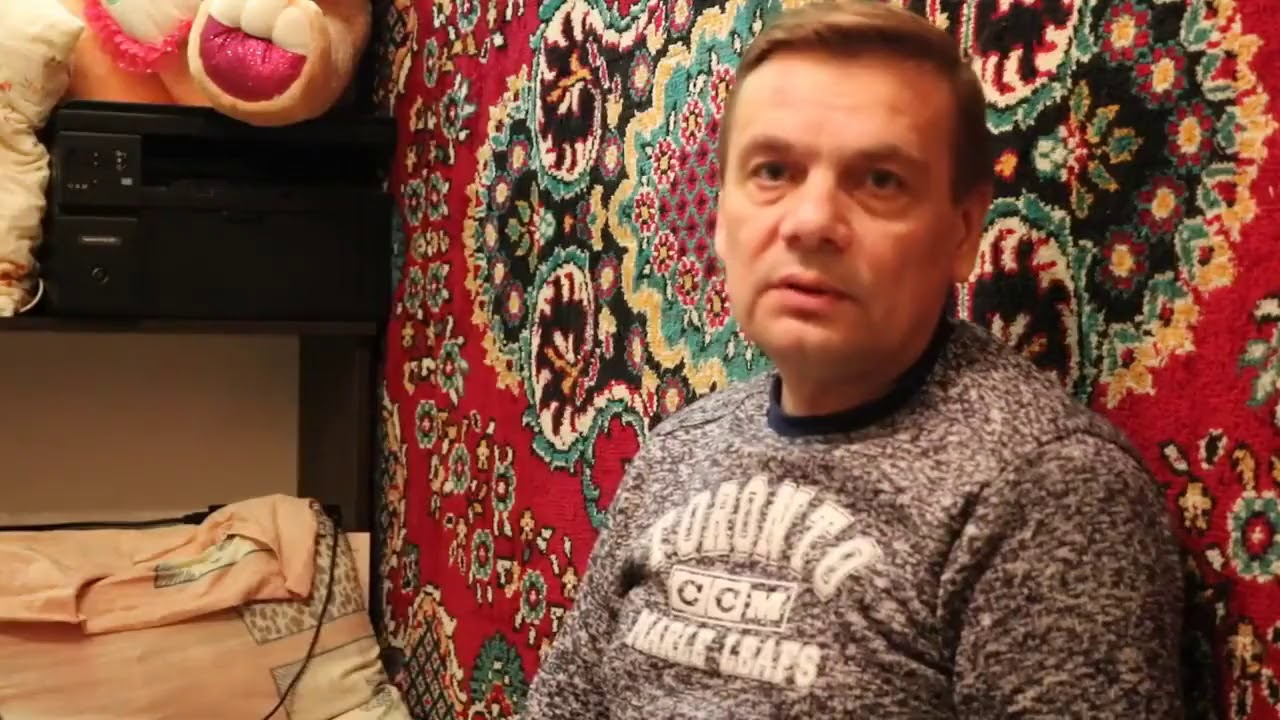

##### Мы изучили различные типы шкалирования и построения регрессионных моделей. 
##### Изучили важность признаков

### Лучшие наборы шкалирования и построения моделей

In [217]:
data_metrics[(data_metrics['Train RMSE']<84)]

,Scaler,Model,Test RMSE,Train RMSE,Test MAE,Train MAE,Test R2,Train R2
0,StandardScaler(),LinearRegression(),81.8,83.93,52.05,52.63,0.36,0.35
0,StandardScaler(),Ridge(alpha=100),81.8,83.93,52.04,52.61,0.36,0.35
0,RobustScaler(),LinearRegression(),81.8,83.93,52.05,52.63,0.36,0.35
0,RobustScaler(),Ridge(alpha=100),81.8,83.93,52.03,52.60,0.36,0.35
0,MinMaxScaler(),LinearRegression(),81.8,83.93,52.05,52.63,0.36,0.35
